Trabajo Práctico 4: Aprendizaje No-Supervisado

In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import src.preprocessing as pre
import src.metrics as metrics
import src.models as models
import src.pytorchmodels as torchmodels

X, y = pre.load_faces_csv("data/caras.csv")
np.random.seed(0)



1. Inspección de los datos

1.1 Primera Observacion de los Datos

Comienzo por observar 15 imagenes seleccionadas de manera aleatoria.

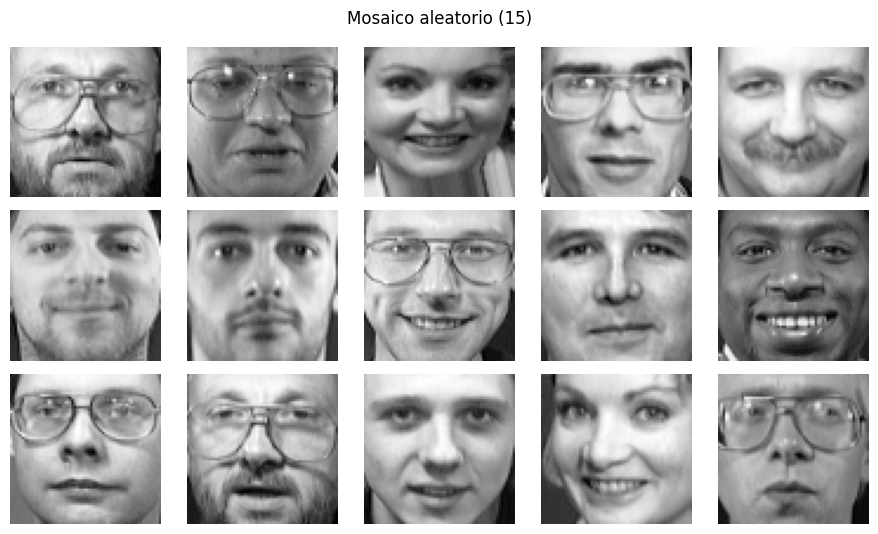

In [2]:
idxs = np.random.choice(len(X), size=15, replace=False)
pre.plot_images(X, idxs, img_shape=(64, 64), suptitle="Mosaico aleatorio (15)");

1.2 Analisis Exploratorio de la Distribución de Clases

Grafico muestras agrupadas por clase, para 5 clases.

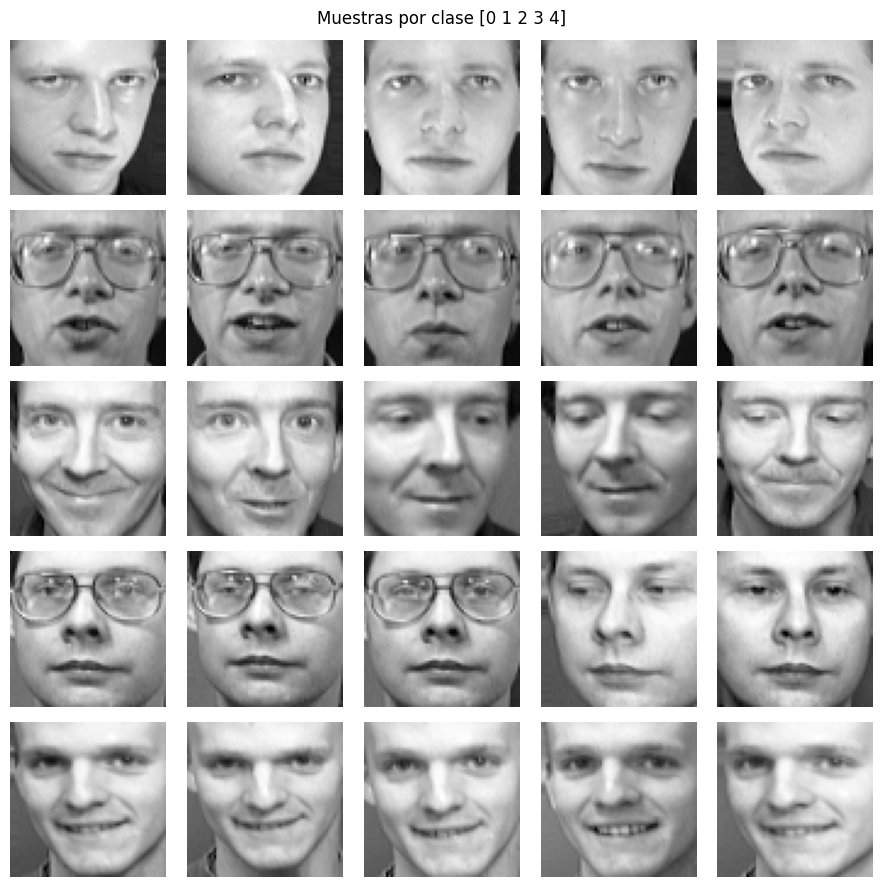

In [3]:
# distribución de clases
vals, counts = np.unique(y, return_counts=True)

# muestras por 5 clases (elige automáticamente las 5 más frecuentes)
top5 = vals[np.argsort(-counts)[:5]]
pre.plot_by_class(X, y, top5, per_class=5);

Grafico la distribucion de las clases

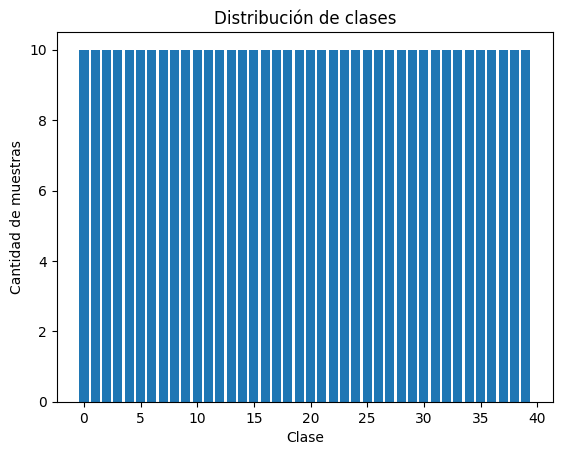

In [4]:
# grafico la distribucion de las clases
plt.bar(vals, counts)
plt.xlabel("Clase")
plt.ylabel("Cantidad de muestras")
plt.title("Distribución de clases")
plt.show()

Las clases estan perfectamente balanceadas con igual cantidad de muestras por clase. Por el momento no aplico ningun cambio en el dataset.

1.3 Split de los Datos

Separo los datos en Train (80%) y Test (20%)

In [5]:
# split estratificado 80/20
(Xtr, ytr), (Xte, yte) = pre.stratified_split(X, y, test_size=0.2, random_state=0)

2. Reducción de dimensionalidad

2.1 Aplicación de PCA

Estandarización de los datos

In [6]:
std = pre.standardize_fit(Xtr)
Xtr_std = pre.standardize_transform(Xtr, std)
Xte_std = pre.standardize_transform(Xte, std)

Aplico PCA a los datos estandarizados

In [7]:
pca = pre.pca_fit(Xtr_std)

2.2 Analisis del PCA

Grafico de la varianza explicada acumulada en función del numero de componentes

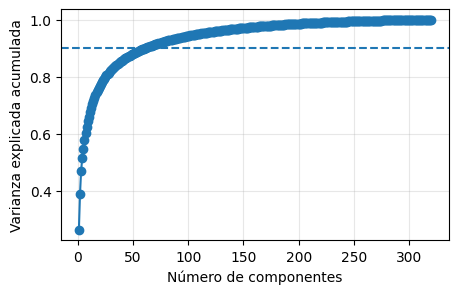

In [8]:

fig = pre.explained_variance_plot(pca)


Me quedo con el número de componentes que me aseguren explicar el 90 % de la
varianza de los dato denotada por la linea punteada del grafico anterior

In [9]:
k90 = pre.pca_choose_k_from_variance(pca["cum_explained_ratio"], 0.90)  # 90% var (2.b)
Ztr_pca = pre.pca_transform(Xtr_std, pca, k=k90)
Zte_pca = pre.pca_transform(Xte_std, pca, k=k90)

Para comparar los datos originales con la reduccion de dimensionalidad hecha con PCA grafico 10 imagenes

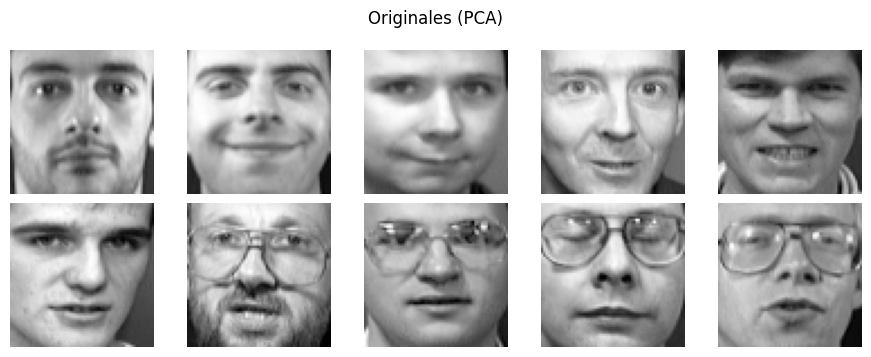

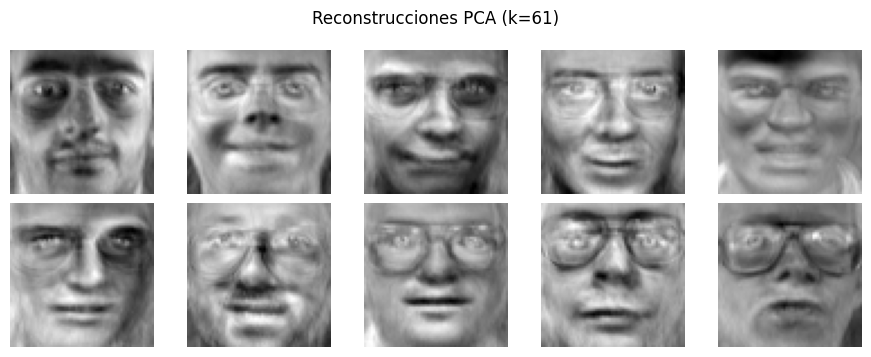

In [10]:
# Reconstrucciones con k90 y comparación visual (2.b)
Xtr_rec = pre.pca_inverse_transform(Ztr_pca, pca, k=k90, X_mean=Xtr.mean(axis=0, keepdims=True))
idxs = np.random.choice(len(Xtr), size=10, replace=False)
pre.plot_images(Xtr, idxs, suptitle="Originales (PCA)");
pre.plot_images(Xtr_rec, idxs, suptitle=f"Reconstrucciones PCA (k={k90})");

2.3 Aplicacion de AutoEncoder Deterministico

Para la implementacion del Autoencoder utilizo PyTorch

In [11]:
import torch, torch.nn as nn, torch.optim as optim

Defino el modelo y convierto los datos a tensores

In [12]:
D = Xtr_std.shape[1]
k = k90

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae = torchmodels.Autoencoder(D, k).to(device)
opt = optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

# Convierto los datos a tensores y muevo a device
Xtr_t = torch.from_numpy(Xtr_std).float().to(device)
Xte_t = torch.from_numpy(Xte_std).float().to(device)


Entrenamiento y evaluacion del autoencoder

In [13]:
for epoch in range(50):
    ae.train()
    opt.zero_grad()
    xr, _ = ae(Xtr_t)
    loss = loss_fn(xr, Xtr_t)
    loss.backward(); opt.step()

ae.eval()
with torch.no_grad():
    xr_val, z_val = ae(Xte_t)
Xte_rec = xr_val.cpu().numpy()

2.4 Comparacion entre Las imagenes reconstruidas con PCA y AE

Grafico el las imagenes originales, las de PCA y las del AE

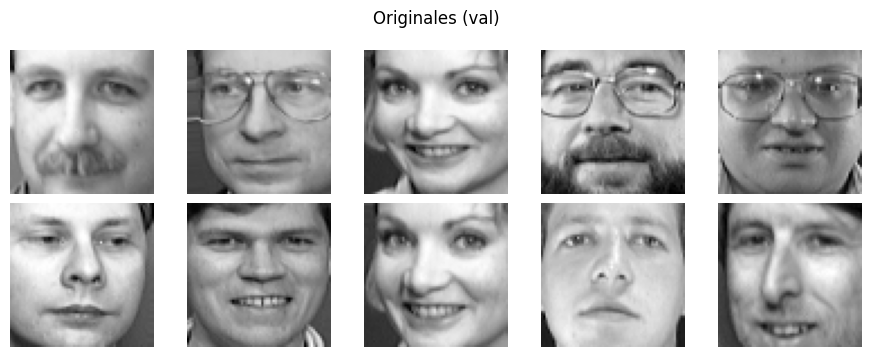

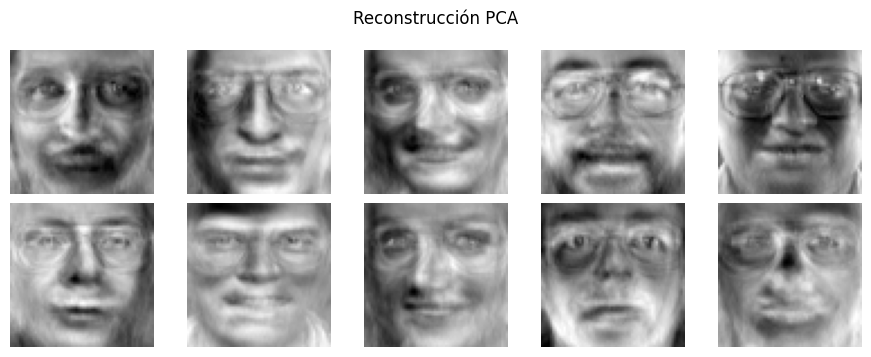

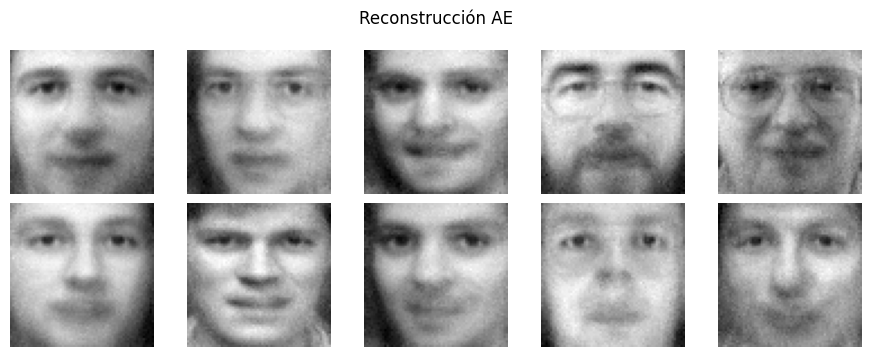

In [14]:

idxs = np.random.choice(len(Xte), size=10, replace=False)
pre.plot_images(Xte, idxs, suptitle="Originales (val)");
pre.plot_images(pre.pca_inverse_transform(pre.pca_transform(Xte_std, pca, k), pca, k, X_mean=Xte.mean(0, keepdims=True)), idxs, suptitle="Reconstrucción PCA");
pre.plot_images((Xte_rec * std["sigma"] + std["mu"]), idxs, suptitle="Reconstrucción AE");


2.5 Aplicación de las transformaciones aprendida a train y test

In [15]:
# Z de PCA ya están (Ztr_pca, Zte_pca)
Ztr_ae = z_val.cpu().numpy() if 'z_val' in locals() else None  # si querés, recalcular sobre train también
with torch.no_grad():
    z_tr = ae.enc(torch.from_numpy(Xtr_std).float().to(device)).cpu().numpy()
    z_te = ae.enc(torch.from_numpy(Xte_std).float().to(device)).cpu().numpy()


3. Clustering

3.1 Implementación de K-Means

Pruebo valores de K dentro del rango de [5, 20] 

In [16]:
Ks = range(5, 21)
results = []
for rep_space, Ztr in [("PCA", Ztr_pca), ("AE", z_tr)]:
    inertias = []
    sils = []
    for K in Ks:
        km = models.KMeans(n_clusters=K, n_init=5, max_iter=300, random_state=0).fit(Ztr)
        inertias.append(km.inertia_)
        sils.append(metrics.silhouette_score(Ztr, km.labels_))
    results.append((rep_space, np.array(inertias), np.array(sils)))

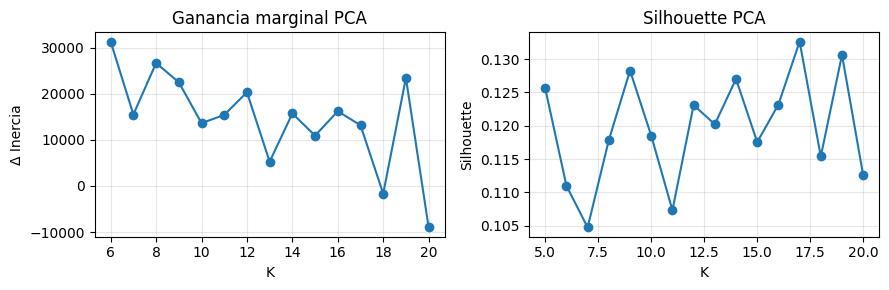

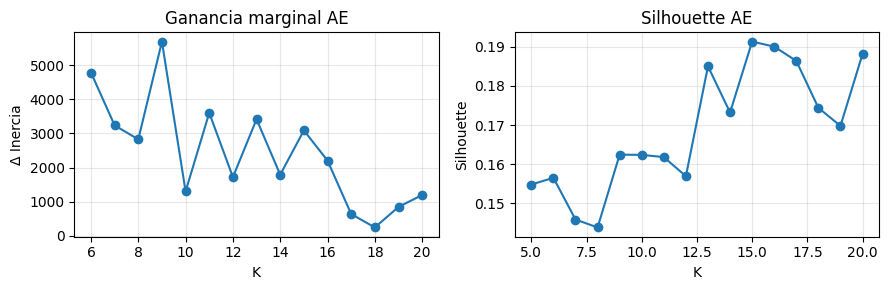

In [17]:
# graficar elbow (ganancia marginal) y silhouette (3.c)
import matplotlib.pyplot as plt
for rep_space, inertias, sils in results:
    gains = metrics.elbow_gains(inertias)
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    ax[0].plot(list(Ks), gains, marker='o'); ax[0].set_title(f'Ganancia marginal {rep_space}')
    ax[0].set_xlabel('K'); ax[0].set_ylabel('Δ Inercia'); ax[0].grid(True, alpha=0.3)
    ax[1].plot(list(Ks), sils, marker='o'); ax[1].set_title(f'Silhouette {rep_space}')
    ax[1].set_xlabel('K'); ax[1].set_ylabel('Silhouette'); ax[1].grid(True, alpha=0.3)
    plt.tight_layout()

3.2 Implementación de GMM

Pruebo valores de K dentro del rango de [5, 20] 

d:\Archivos\UdeSA\IngIA\2025\Machine Learning\Tp4-Aprendizaje-No-Supervisado\src\metrics.py:25: RuntimeWarning: invalid value encountered in scalar divide
  S[i] = 0.0 if max(a, b) == 0 else (b - a) / max(a, b)


Sugerencia por BIC: K = 5
Sugerencia por Silhouette: K = 5
Sugerencia por BIC: K = 5
Sugerencia por Silhouette: K = 20


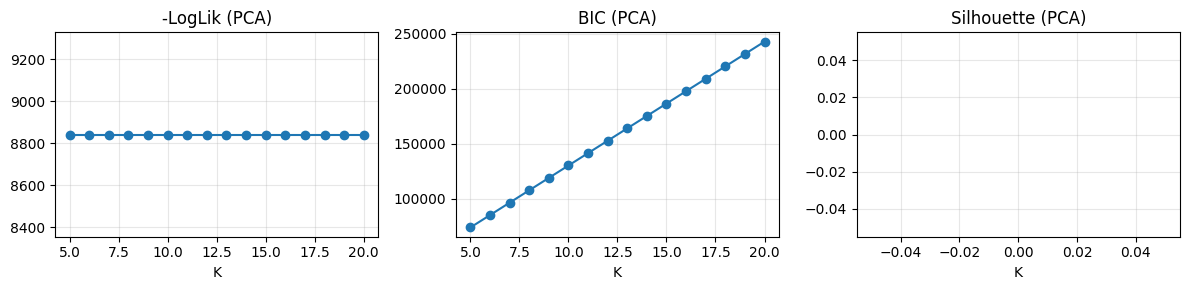

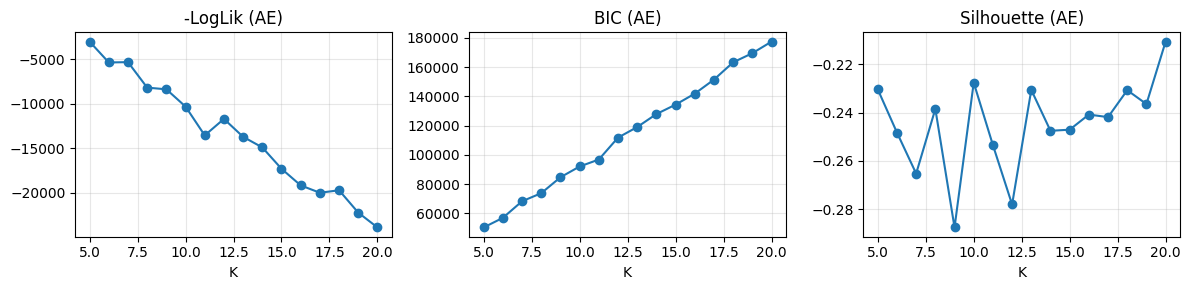

In [18]:
Ks = range(5, 21)

def plot_gmm_model_selection(res, title_suffix=""):
    Ks = res["Ks"]
    fig, ax = plt.subplots(1,3, figsize=(12,3))
    ax[0].plot(Ks, -res["loglik"], marker="o"); ax[0].set_title(f"-LogLik {title_suffix}")
    ax[0].set_xlabel("K"); ax[0].grid(True, alpha=0.3)
    ax[1].plot(Ks, res["BIC"], marker="o"); ax[1].set_title(f"BIC {title_suffix}")
    ax[1].set_xlabel("K"); ax[1].grid(True, alpha=0.3)
    ax[2].plot(Ks, res["silhouette"], marker="o"); ax[2].set_title(f"Silhouette {title_suffix}")
    ax[2].set_xlabel("K"); ax[2].grid(True, alpha=0.3)
    plt.tight_layout()
    # sugerencias automáticas
    k_bic = Ks[np.argmin(res["BIC"])]
    k_sil = Ks[np.argmax(res["silhouette"])]
    print(f"Sugerencia por BIC: K = {k_bic}")
    print(f"Sugerencia por Silhouette: K = {k_sil}")
    return k_bic, k_sil

# En PCA
res_pca = models.gmm_sweep_over_K(Ztr_pca, Ks, n_init=5, random_state=0)
k_bic_pca, k_sil_pca = plot_gmm_model_selection(res_pca, title_suffix="(PCA)")

# En AE
res_ae = models.gmm_sweep_over_K(z_tr, Ks, n_init=5, random_state=0)
k_bic_ae, k_sil_ae = plot_gmm_model_selection(res_ae, title_suffix="(AE)")
